<a href="https://colab.research.google.com/github/pragy19/StressDetection/blob/main/stress_rf_combined(time_domain).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    roc_auc_score, roc_curve, auc
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


In [ ]:
# Step 2: Load Combined Dataset
old_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stress/train.csv")
test1 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stress/test.csv")
new_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stress/new_train.csv")
test2 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/stress/new_test.csv")


In [ ]:
# Step 3: Rename Condition Column to Label
for df in [old_train, new_train, test1, test2]:
    df.rename(columns={'condition': 'label'}, inplace=True)

In [ ]:
# Step 4: Define Core Features and Combine Data
core_features = ['MEAN_RR', 'SDRR', 'RMSSD', 'HR', 'pNN25', 'pNN50']

# Combine training data
X_train_combined = pd.concat([old_train[core_features], new_train[core_features]], axis=0)
y_train_combined = pd.concat([old_train['label'], new_train['label']], axis=0)

# Combine test data
X_test_combined = pd.concat([test1[core_features], test2[core_features]], axis=0)
y_test_combined = pd.concat([test1['label'], test2['label']], axis=0)


In [ ]:
# Step 5: Encode Labels (ensure consistency)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_combined)
y_test_encoded = label_encoder.transform(y_test_combined)

In [ ]:
# Step 6: Scale Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_combined)
X_test_scaled = scaler.transform(X_test_combined)

In [ ]:
# Step 7: Handle Class Imbalance Using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_encoded)

In [ ]:
# Step 8: Split into Train and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)

In [ ]:
# Step 9: Compute Class Weights
sample_weights = compute_sample_weight('balanced', y_train)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Step 10: Define Random Forest Classifier
model = RandomForestClassifier(
    n_estimators=100,
    random_state=42
)

# Step 11: Fit the Model with Sample Weights
model.fit(
    X_train, y_train,
    sample_weight=sample_weights
)


RandomForestClassifier(random_state=42)

In [ ]:
# Predict on training data
y_train_pred = model.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_acc:.4f}")

# Predict on validation data
y_val_pred = model.predict(X_val)
val_acc = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_acc:.4f}")

# Predict on test data
y_test_pred = model.predict(X_test_scaled)
test_acc = accuracy_score(y_test_encoded, y_test_pred)
print(f"Test Accuracy: {test_acc:.4f}")



Training Accuracy: 0.9982
Validation Accuracy: 0.9932
Test Accuracy: 0.9944


In [ ]:
# Classification Report
class_report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_)
print("\nClassification Report:\n", class_report)



Classification Report:
                precision    recall  f1-score   support

 interruption       1.00      0.98      0.99     22897
    no stress       1.00      1.00      1.00     43468
time pressure       0.98      0.99      0.98     13832

     accuracy                           0.99     80197
    macro avg       0.99      0.99      0.99     80197
 weighted avg       0.99      0.99      0.99     80197



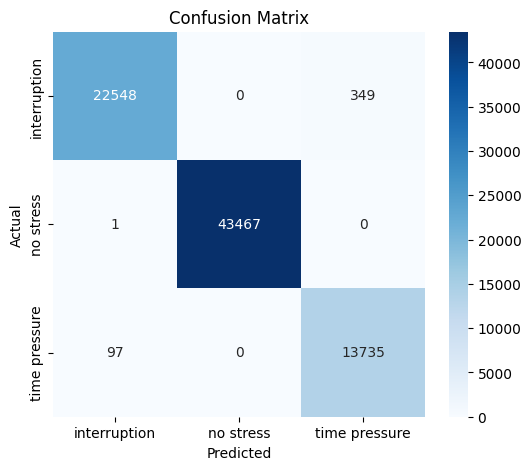

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()